In [1]:
import os
root = os.getcwd()
print(root)

/Users/kinbunhua/cs521/group


Figure 1. Samples of Nasi from the data-set:

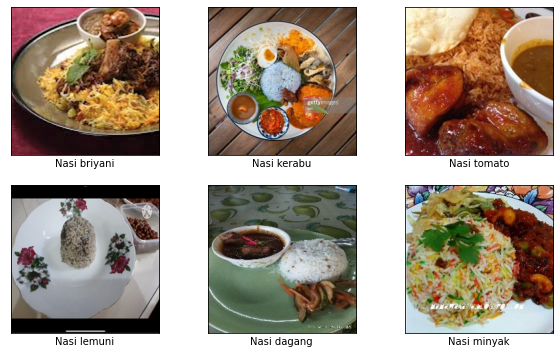

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

DATADIR = root + "/Nasi"

CATEGORIES = ["Nasi briyani", "Nasi kerabu", "Nasi tomato", "Nasi lemuni", "Nasi dagang", "Nasi minyak"]

plt.figure(figsize = (10, 6))
i = 0
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    i = i + 1
    plt.subplot(2, 3, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #print(path)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        #print(os.path.join(path,img))
        img_array = mpimg.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.xlabel(category)
        break  # we just want one for now so break
plt.show()  # display!

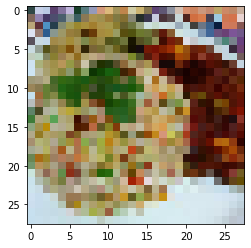

In [3]:
IMG_SIZE = 28

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 300/300 [00:00<00:00, 591.70it/s]

1824


In [5]:
import random

random.shuffle(training_data)

In [6]:
X = []
y = []
channels = 3
num_classes = len(CATEGORIES)
INPUT_SIZE = IMG_SIZE * IMG_SIZE * channels
for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X.shape, y.shape)
#import train_test_split function
from sklearn.model_selection import train_test_split

#split the dataset into training and test sets 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
print(num_classes)
print(y[0])
print(y[1])

6
3
4


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#defines the options for augmentation 
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation 
    image : raw image 
    nb_augmentation: number of augmentations 
    images: array with new images 
    '''
    images = [] 
    image = image.reshape(1, IMG_SIZE, IMG_SIZE, channels)
    i = 0 
    for x_batch in datagen.flow(image, batch_size = 1):
        images.append(x_batch)
        i += 1 
        if i >= nb_of_augmentation:
            #interrupt augmentation 
            break 
    return images 

In [9]:
import tensorflow as tf 
def create_model():
    '''
    Creates a simaple sequential model
    '''

    cnn = tf.keras.Sequential()

    cnn.add(tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, channels)))

    #normalization 
    cnn.add(tf.keras.layers.BatchNormalization())

    #conv + maxpooling 
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding = "same", activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

    #drop out 
    cnn.add(tf.keras.layers.Dropout(0.1))

    #conv + Maxpooling 
    cnn.add(tf.keras.layers.Convolution2D(64, (4,4), activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

    #dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    #converting 3d feature to 1d feature vektor 
    cnn.add(tf.keras.layers.Flatten())

    #fully connected layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    #dropout 
    cnn.add(tf.keras.layers.Dropout(0.5))

    #Fully connected layer 
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))

    #normalization 
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics = ['accuracy'])

    return cnn 


In [10]:
import tensorflow as tf 

def preprocess_data(images, targets, use_augmentation = False, nb_of_augmentation = 1):
    '''
    images : raw image 
    targets : target label
    use_augmentation : True if augmentation should be used 
    nb_of_augmentation : if use_augmentation = True, number of augmentations 
    '''
    X = []
    y = [] 
    for x_, y_ in zip(images, targets):
        #scaling pixels between 0.0-1.0 
        x_ = x_ / 255. 

        #data augmentation 
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(IMG_SIZE, IMG_SIZE, channels))
                y.append(y_)
        
        X.append(x_.reshape(IMG_SIZE, IMG_SIZE, channels))
        y.append(y_)

    print("*Preprocessiong completed:%i samples\n" % len(X))
    #print(X)
    firstargu = np.array(X)
    print(firstargu.shape)
    secondargu = tf.keras.utils.to_categorical(y)
    return firstargu, secondargu

In [11]:
nb_augmentation = 2 #defines the number of additional augmentations of one image
X_train_shaped, y_train_shaped = preprocess_data(
    X, y,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = preprocess_data(X_test, y_test)

*Preprocessiong completed:4377 samples

(4377, 28, 28, 3)
*Preprocessiong completed:365 samples

(365, 28, 28, 3)


In [13]:
from sklearn.model_selection import train_test_split 
histories = []
batch_size = 20
num_epochs = 80   #original 80  
iterations = 3   #original 5 number of iterations

for i in range(0, iterations):
    print('Running iteration:%i' % i)

    #saving the best checkpoint for each iteration 
    filepath = 'nasi-%i.hdf5' % i

    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped, test_size=0.2, random_state=42)

    cnn = create_model()
    history = cnn.fit(
        X_train_, y_train_,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val_, y_val_),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )
    histories.append(history.history)

Running iteration:0
Epoch 1/80
176/176 [==============================] - ETA: 0s - loss: 1.6593 - accuracy: 0.3325
Epoch 1: val_loss improved from inf to 1.42400, saving model to nasi-0.hdf5
176/176 [==============================] - 10s 50ms/step - loss: 1.6593 - accuracy: 0.3325 - val_loss: 1.4240 - val_accuracy: 0.4463
Epoch 2/80
176/176 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.5113
Epoch 2: val_loss improved from 1.42400 to 1.02751, saving model to nasi-0.hdf5
176/176 [==============================] - 9s 50ms/step - loss: 1.2469 - accuracy: 0.5113 - val_loss: 1.0275 - val_accuracy: 0.6301
Epoch 3/80
175/176 [============================>.] - ETA: 0s - loss: 1.1008 - accuracy: 0.5926
Epoch 3: val_loss improved from 1.02751 to 0.81779, saving model to nasi-0.hdf5
176/176 [==============================] - 8s 48ms/step - loss: 1.1009 - accuracy: 0.5927 - val_loss: 0.8178 - val_accuracy: 0.6998
Epoch 4/80
175/176 [============================>.] - ETA: 

In [14]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	0.08828663 loss / 0.97172236 acc
Validation: 	0.24797971 loss / 0.92884322 acc


In [17]:
test_loss = []
test_accs = []

for i in range(0, iterations): 
    cnn_ = tf.keras.models.load_model("nasi-%i.hdf5" % i)
    
    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

running final test with model 0: 1.1327 loss / 0.7096 acc
running final test with model 1: 1.1197 loss / 0.7288 acc
running final test with model 2: 0.9242 loss / 0.7644 acc

Average loss / accuracy on testset: 1.0589 loss / 0.73425 acc
Standard deviation: (+-0.0954) loss / (+-0.0227) acc


In [18]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #accuracy 
    ax1.set_title("Model accuracy (%s)" % title)

    names = []

    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append("Model %i" % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')

    #Loss 
    ax2.set_title("model loss (%s)" % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc = 'upper right')
    fig.set_size_inches(20, 5)
    plt.show()

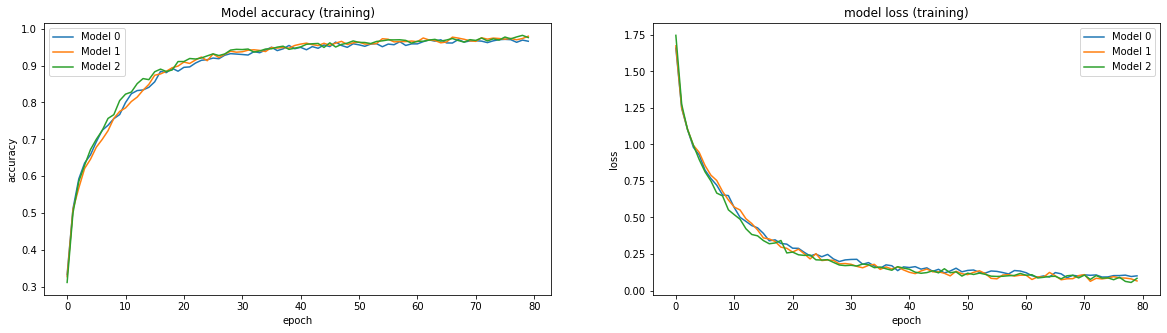

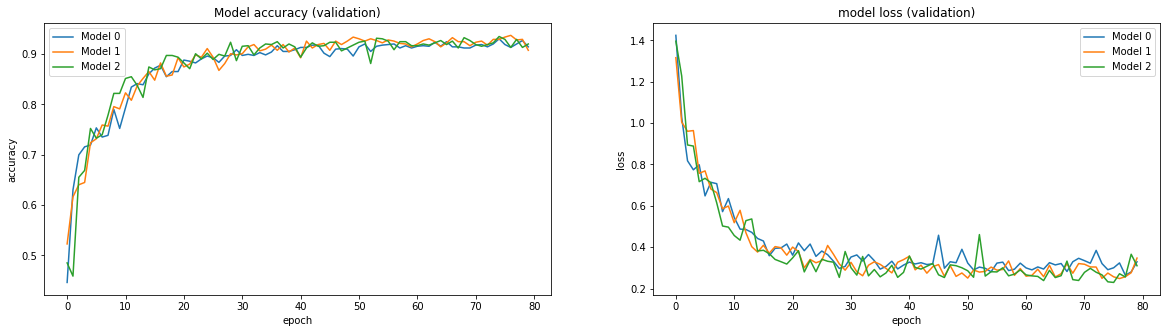

In [19]:
plot_acc_loss("training", histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

In [20]:
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights("nasi-%i.hdf5" % RUN)

In [21]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #Accuracy 
    ax1.set_title("Model accuracy - %s" % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    #loss 
    ax2.set_title("model loss - %s" % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc = 'upper left')

    fig.set_size_inches(20,5)
    plt.show()

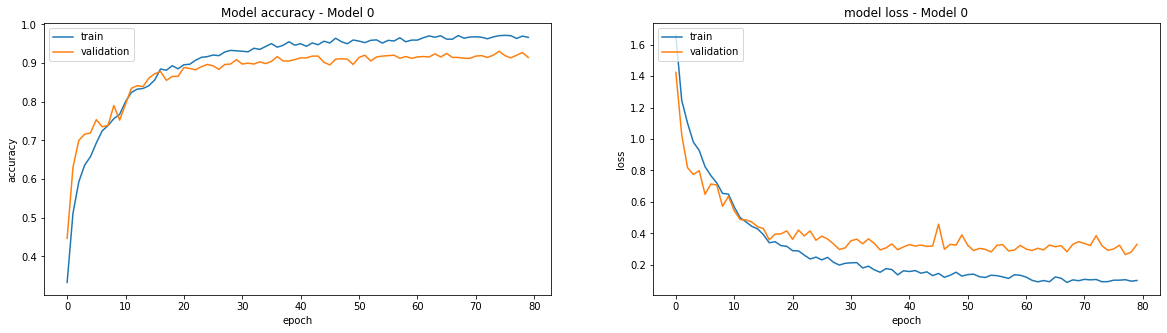

In [22]:
plot_train_val("Model %i" % RUN, histories[RUN])

In [59]:
import numpy as np 
a = np.arange(6).reshape(2, 3)

b = np.argwhere(a > 1)
print(b)

[[0 2]
 [1 0]
 [1 1]
 [1 2]]


In [94]:
def plot_sample_predictions(classes, model, X_test, y_test):
    '''
    this function displays images randomly and tries to predict the correct class
    '''

    class_ = 0
    images_per_row = 3 
    rows = int(len(classes) / images_per_row)  #image_per_row
    #print(rows, X_test, y_test)
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)
        #print(axis)
        for i, axis in enumerate(axis):
            #print(class_, i, axis)
            elements = np.squeeze(np.argwhere(y_test == class_))
            len_e = len(elements) 
            random = np.random.randint(len_e)
            #print(random, elements, elements[random])
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)

            x_reshape = X.reshape([1, IMG_SIZE, IMG_SIZE, channels])
            axis.text(0, 32, 'Predicted:{}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0, 36, 'Correct:{}'.format(classes[y]))
            axis.imshow(np.squeeze(X), cmap = 'gray')
            
            axis.axis('off')
            class_ += 1
    plt.show()

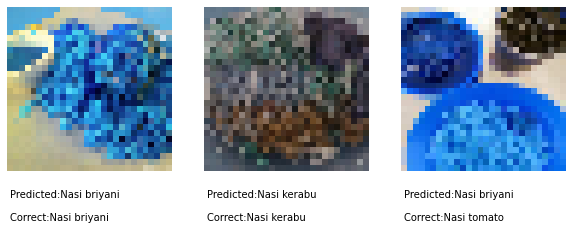

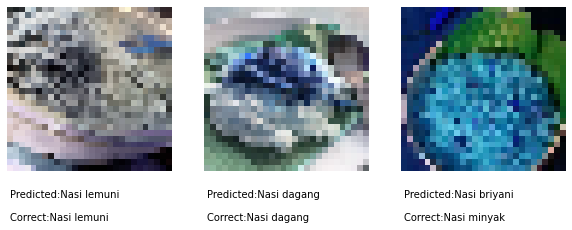

In [95]:
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))